In [1]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

In [7]:
features = pd.read_csv('features_filtered.csv', encoding='latin')
features.head()

,id,gen,sp,ssp,en,cnt,loc,type,q,length,bird-seen,file
0,564895,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Lyons Township (near Willow Springs), Cook Co...","adult, sex uncertain, song",no score,0:16,no,//www.xeno-canto.org/564895/download
1,545775,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Valley Forge National Historical Park, Montgom...",call,no score,0:17,yes,//www.xeno-canto.org/545775/download
2,540857,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Slaterville Rd @ Honness (near Ithaca), Tompk...",song,no score,0:32,unknown,//www.xeno-canto.org/540857/download
3,540855,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Slaterville Rd @ Honness (near Ithaca), Tompk...",song,no score,0:52,unknown,//www.xeno-canto.org/540855/download
4,539275,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,Upper St. Clair Township (near Upper Saint Cl...,"call, song",no score,1:12,yes,//www.xeno-canto.org/539275/download


In [8]:
# These are the top species we selected for our analysis
selected_species = ['Red-winged Blackbird', 
                    'Common Yellowthroat', 
                    'Northern Cardinal', 
                    'Carolina Wren', 
                    'Red Crossbill', 
                    'Spotted Towhee']
# We only need the id and the labels for our CNN.
dataset = features[features.en.isin(selected_species)][['id', 'en']]
# Now we need to change our labels into integers as torch does not support string format for labels.
labels = {"Red-winged Blackbird": 0, 'Common Yellowthroat': 1, 'Northern Cardinal': 2, 'Carolina Wren': 3,
          'Red Crossbill': 4, 'Spotted Towhee': 5}
dataset['label'] = dataset.apply(lambda row: labels[row.en], axis=1)
dataset.drop('en', axis=1, inplace=True)

# Taking 20% of the dataset off for testing
train, test = train_test_split(dataset, test_size=0.2)

print(train.label.value_counts())
print('')
print(test.label.value_counts())

5    394
2    348
0    336
4    321
3    320
1    293
Name: label, dtype: int64

5    112
0    100
2     86
3     82
4     63
1     61
Name: label, dtype: int64


In [9]:
def load_images(dataset, dimensions='2D', gray=True):
    img_df = []
    for img_name in tqdm(dataset['id']):
        # defining the image path
        image_path = 'images/mel_spectrograms_8sec/' + str(img_name) + '.jpg'
        # reading the image
        img = imread(image_path, as_gray=gray)
        # normalizing the pixel values
        img /= 255.0
        # converting the type of pixel to float 32
        img = img.astype('float32')
        # appending the image into the list
        if dimensions == '1D':
            img_df.append(img.flatten())
        else:
            img_df.append(img)
    
    # converting the list to numpy array
    return np.array(img_df)

def visualizing_images(dataset):
    # Only works for 2D arrays
    i = 0
    plt.figure(figsize=(10,10))
    plt.subplot(221), plt.imshow(dataset[i], cmap='gray')
    plt.subplot(222), plt.imshow(dataset[i+25], cmap='gray')
    plt.subplot(223), plt.imshow(dataset[i+50], cmap='gray')
    plt.subplot(224), plt.imshow(dataset[i+75], cmap='gray')

# Random Forest 

In [10]:
X_train, y_train = load_images(train, dimensions='1D', gray=True), train['label'].values
X_train.shape

100%|█████████████████████████████████████████████████████████████████████████████| 2012/2012 [00:17<00:00, 115.92it/s]


(2012, 435456)

In [11]:
X_test, y_test = load_images(test, dimensions='1D', gray=True), test['label'].values
X_test.shape

100%|███████████████████████████████████████████████████████████████████████████████| 504/504 [00:04<00:00, 116.68it/s]


(504, 435456)

In [13]:
X_train.shape

(2012, 435456)

In [14]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Random Forest Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [15]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.47619047619047616


In [16]:
from sklearn.metrics import f1_score
print("F1 score: ", f1_score(y_test, y_pred, average='micro'))
print("F1 score: ", f1_score(y_test, y_pred, average='weighted'))

F1 score:  0.47619047619047616
F1 score:  0.4699259512263259


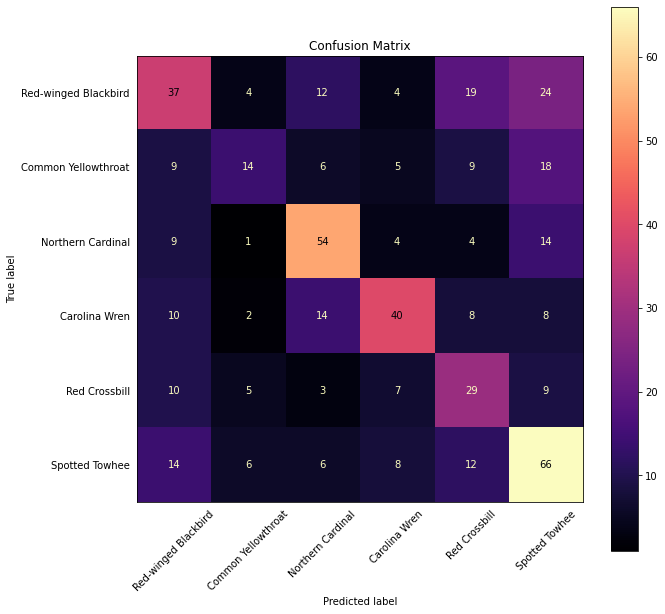

In [17]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=selected_species)
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('Predicted labels')
ax.tick_params(axis = "both", which = "both", bottom = False, left=False)
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
disp.plot(ax=ax, xticks_rotation=45, cmap='magma')